# 预测集与训练误差估计

In [2]:
library(mlr3verse)

Loading required package: mlr3



In [3]:
# 创建任务和学习器
tsk_sonar <- tsk("sonar")
lrn_rf <- lrn("classif.ranger")

# 训练模型，使用第4到208行作为训练集
lrn_rf$train(tsk_sonar, row_ids = 4:208)

# 对第1到3行进行预测
pred1 <- lrn_rf$predict(tsk_sonar, row_ids = 1:3)
pred2 <- lrn_rf$predict_newdata(tsk_sonar$data(rows = 1:3))

In [4]:
lrn_rf$predict_sets <- c("train", "test")
rr <- resample(tsk_sonar, lrn_rf, rsmp("cv", folds = 3))

INFO  [14:42:27.158] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 1/3)
INFO  [14:42:27.239] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 2/3)
INFO  [14:42:27.459] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 3/3)


In [ ]:
str(rr$predictions("test")) # or str(rr$predictions("train"))

# List of 3
#  $ :Classes 'PredictionClassif', 'Prediction', 'R6' <PredictionClassif> 
#  $ :Classes 'PredictionClassif', 'Prediction', 'R6' <PredictionClassif> 
#  $ :Classes 'PredictionClassif', 'Prediction', 'R6' <PredictionClassif>

List of 3
 $ :Classes 'PredictionClassif', 'Prediction', 'R6' <PredictionClassif> 
 $ :Classes 'PredictionClassif', 'Prediction', 'R6' <PredictionClassif> 
 $ :Classes 'PredictionClassif', 'Prediction', 'R6' <PredictionClassif> 


In [ ]:
rr$prediction("test") # or rr$prediction("train")

# <PredictionClassif> for 208 observations:
#  row_ids truth response
#        1     R        R
#        2     R        M
#        3     R        M
#      ---   ---      ---
#      206     M        M
#      207     M        M
#      208     M        M

<PredictionClassif> for 208 observations:
 row_ids truth response
       1     R        R
       2     R        M
       3     R        M
     ---   ---      ---
     206     M        M
     207     M        M
     208     M        M

In [ ]:
rr$aggregate(list(
  msr("classif.ce", predict_sets = "train", id = "ce_train"),
  msr("classif.ce", predict_sets = "test", id = "ce_test")
))

# ce_train   ce_test 
# 0.0000000 0.2017253

ce_train   ce_test 
0.0000000 0.2017253

In [ ]:
lrn_rf$predict_sets <- NULL
rsmp_in <- rsmp("insample")
rr <- resample(tsk_sonar, lrn_rf, rsmp_in, store_models = TRUE)
msr_oob <- msr("oob_error")
rr$aggregate(msr_oob)

# oob_error 
# 0.1634615

INFO  [14:48:50.292] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 1/1)


oob_error 
0.1634615

In [9]:
lrn_rf$param_set$set_values(
  mtry.ratio = to_tune(0.1, 1)
)

ti <- tune(
  task = tsk_sonar,
  tuner = tnr("grid_search"),
  learner = lrn_rf,
  resampling = rsmp_in,
  measure = msr_oob,
  term_evals = 10,
  store_models = TRUE
)

INFO  [14:49:24.555] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [14:49:24.564] [bbotk] Evaluating 1 configuration(s)
INFO  [14:49:24.605] [mlr3] Running benchmark with 1 resampling iterations
INFO  [14:49:24.609] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 1/1)
INFO  [14:49:24.795] [mlr3] Finished benchmark
INFO  [14:49:24.816] [bbotk] Result of batch 1:
INFO  [14:49:24.818] [bbotk]  mtry.ratio oob_error warnings errors runtime_learners
INFO  [14:49:24.818] [bbotk]         0.5 0.1682692        0      0            0.179
INFO  [14:49:24.818] [bbotk]                                 uhash
INFO  [14:49:24.818] [bbotk]  bccf9285-5d58-4bc2-9011-c3f18a6fd8ff
INFO  [14:49:24.819] [bbotk] Evaluating 1 configuration(s)
INFO  [14:49:24.823] [mlr3] Running benchmark with 1 resampling iterations
INFO  [14:49:24.826] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 1/1)
INFO  [14:49:25.

# 验证

In [ ]:
tsk_sonar <- tsk("sonar")
lrn_xgb <- lrn("classif.xgboost")
lrn_xgb

# <LearnerClassifXgboost:classif.xgboost>: Extreme Gradient Boosting
# * Model: -
# * Parameters: nrounds=1000, nthread=1, verbose=0
# * Validate: NULL
# * Packages: mlr3, mlr3learners, xgboost
# * Predict Types:  [response], prob
# * Feature Types: logical, integer, numeric
# * Properties: hotstart_forward, importance, internal_tuning, missings,
#   multiclass, offset, twoclass, validation, weights

<LearnerClassifXgboost:classif.xgboost>: Extreme Gradient Boosting
* Model: -
* Parameters: nrounds=1000, nthread=1, verbose=0
* Validate: NULL
* Packages: mlr3, mlr3learners, xgboost
* Predict Types:  [response], prob
* Feature Types: logical, integer, numeric
* Properties: hotstart_forward, importance, internal_tuning, missings,
  multiclass, offset, twoclass, validation, weights

In [ ]:
lrn_xgb$validate <- 1/3

In [12]:
lrn_xgb$param_set$set_values(
  nrounds = 100,
  eval_metric = "logloss"
)
lrn_xgb$train(tsk_sonar)

In [ ]:
tail(lrn_xgb$model$evaluation_log)

# iter test_logloss
# 1  95  0.3316682   
# 2  96  0.3316024   
# 3  97  0.3327876   
# 4  98  0.3325908   
# 5  99  0.3317089   
# 6 100  0.3326335

iter,test_logloss
<dbl>,<dbl>
95,0.3316682
96,0.3316024
97,0.3327876
98,0.3325908
99,0.3317089
100,0.3326335


In [ ]:
lrn_xgb$internal_valid_scores

# $logloss
# [1] 0.3326335

$logloss
[1] 0.3326335

In [15]:
lrn_xgb$validate <- "predefined"

In [16]:
# 随机抽取60个样本作为验证集
valid_ids <- sample(tsk_sonar$nrow, 60)
tsk_valid <- tsk_sonar$clone(deep = TRUE)
tsk_valid$filter(valid_ids)

# 剩余样本作为训练集
tsk_sonar$filter(setdiff(tsk_sonar$row_ids, valid_ids))

# 设置内部验证任务
tsk_sonar$internal_valid_task <- tsk_valid

In [ ]:
c(tsk_sonar$internal_valid_task$nrow, tsk_sonar$nrow)

# [1]  60 148

[1]  60 148

In [18]:
lrn_xgb$train(tsk_sonar)

In [ ]:
po_pca <- po("pca")
taskout <- po_pca$train(list(tsk_sonar))[[1]]
taskout$internal_valid_task

# <TaskClassif:sonar> (60 x 61): Sonar: Mines vs. Rocks
# * Target: Class
# * Properties: twoclass
# * Features (60):
#   - dbl (60): PC1, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17,
#     PC18, PC19, PC2, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27,
#     PC28, PC29, PC3, PC30, PC31, PC32, PC33, PC34, PC35, PC36, PC37,
#     PC38, PC39, PC4, PC40, PC41, PC42, PC43, PC44, PC45, PC46, PC47,
#     PC48, PC49, PC5, PC50, PC51, PC52, PC53, PC54, PC55, PC56, PC57,
#     PC58, PC59, PC6, PC60, PC7, PC8, PC9

<TaskClassif:sonar> (60 x 61): Sonar: Mines vs. Rocks
* Target: Class
* Properties: twoclass
* Features (60):
  - dbl (60): PC1, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17,
    PC18, PC19, PC2, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27,
    PC28, PC29, PC3, PC30, PC31, PC32, PC33, PC34, PC35, PC36, PC37,
    PC38, PC39, PC4, PC40, PC41, PC42, PC43, PC44, PC45, PC46, PC47,
    PC48, PC49, PC5, PC50, PC51, PC52, PC53, PC54, PC55, PC56, PC57,
    PC58, PC59, PC6, PC60, PC7, PC8, PC9

In [ ]:
po_pca$predict(list(tsk_sonar$internal_valid_task))[[1L]]

# <TaskClassif:sonar> (60 x 61): Sonar: Mines vs. Rocks
# * Target: Class
# * Properties: twoclass
# * Features (60):
#   - dbl (60): PC1, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17,
#     PC18, PC19, PC2, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27,
#     PC28, PC29, PC3, PC30, PC31, PC32, PC33, PC34, PC35, PC36, PC37,
#     PC38, PC39, PC4, PC40, PC41, PC42, PC43, PC44, PC45, PC46, PC47,
#     PC48, PC49, PC5, PC50, PC51, PC52, PC53, PC54, PC55, PC56, PC57,
#     PC58, PC59, PC6, PC60, PC7, PC8, PC9

<TaskClassif:sonar> (60 x 61): Sonar: Mines vs. Rocks
* Target: Class
* Properties: twoclass
* Features (60):
  - dbl (60): PC1, PC10, PC11, PC12, PC13, PC14, PC15, PC16, PC17,
    PC18, PC19, PC2, PC20, PC21, PC22, PC23, PC24, PC25, PC26, PC27,
    PC28, PC29, PC3, PC30, PC31, PC32, PC33, PC34, PC35, PC36, PC37,
    PC38, PC39, PC4, PC40, PC41, PC42, PC43, PC44, PC45, PC46, PC47,
    PC48, PC49, PC5, PC50, PC51, PC52, PC53, PC54, PC55, PC56, PC57,
    PC58, PC59, PC6, PC60, PC7, PC8, PC9

In [ ]:
glrn <- as_learner(po_pca %>>% lrn_xgb)

In [22]:
set_validate(glrn, validate = "predefined")
set_validate(glrn, validate = "predefined", ids = "classif.xgboost")

In [ ]:
glrn$validate <- "predefined"
glrn$train(tsk_sonar)
glrn$internal_valid_scores

# $classif.xgboost.logloss
# [1] 0.4456124

$classif.xgboost.logloss
[1] 0.4456124

# 内部调参

In [ ]:
"internal_tuning" %in% lrn_xgb$properties

# [1] TRUE

[1] TRUE

In [25]:
lrn_xgb$param_set$set_values(
  early_stopping_rounds = 10,
  nrounds = 100
)

In [ ]:
lrn_xgb$train(tsk_sonar)
lrn_xgb$internal_tuned_values

# $nrounds
# [1] 100

$nrounds
[1] 100

In [27]:
lrn_xgb$param_set$set_values(
  eta = to_tune(0.001, 0.1, logscale = TRUE),
  nrounds = to_tune(upper = 500, internal = TRUE)
)

In [ ]:
lrn_xgb$validate <- "test"

In [29]:
tsk_sonar <- tsk("sonar")
lrn_xgb$predict_sets <- NULL

ti <- tune(
  task = tsk_sonar,
  tuner = tnr("grid_search"),
  learner = lrn_xgb,
  resampling = rsmp("cv", folds = 3),
  measure = msr("internal_valid_score", select = "logloss", minimize = TRUE),
  term_evals = 10L
)


INFO  [15:06:33.052] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [15:06:33.056] [bbotk] Evaluating 1 configuration(s)
INFO  [15:06:33.059] [mlr3] Running benchmark with 3 resampling iterations
INFO  [15:06:33.065] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/3)
INFO  [15:06:33.327] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 2/3)
INFO  [15:06:33.558] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 3/3)
INFO  [15:06:33.724] [mlr3] Finished benchmark
INFO  [15:06:33.758] [bbotk] Result of batch 1:
INFO  [15:06:33.760] [bbotk]        eta   logloss warnings errors runtime_learners internal_tuned_values
INFO  [15:06:33.760] [bbotk]  -3.837642 0.4251037        0      0            0.608             <list[1]>
INFO  [15:06:33.760] [bbotk]                                 uhash
INFO  [15:06:33.760] [bbotk]  1caf3491-cca8-4fca-aafc-948bc49bbdcc
INFO  [15:06:33.

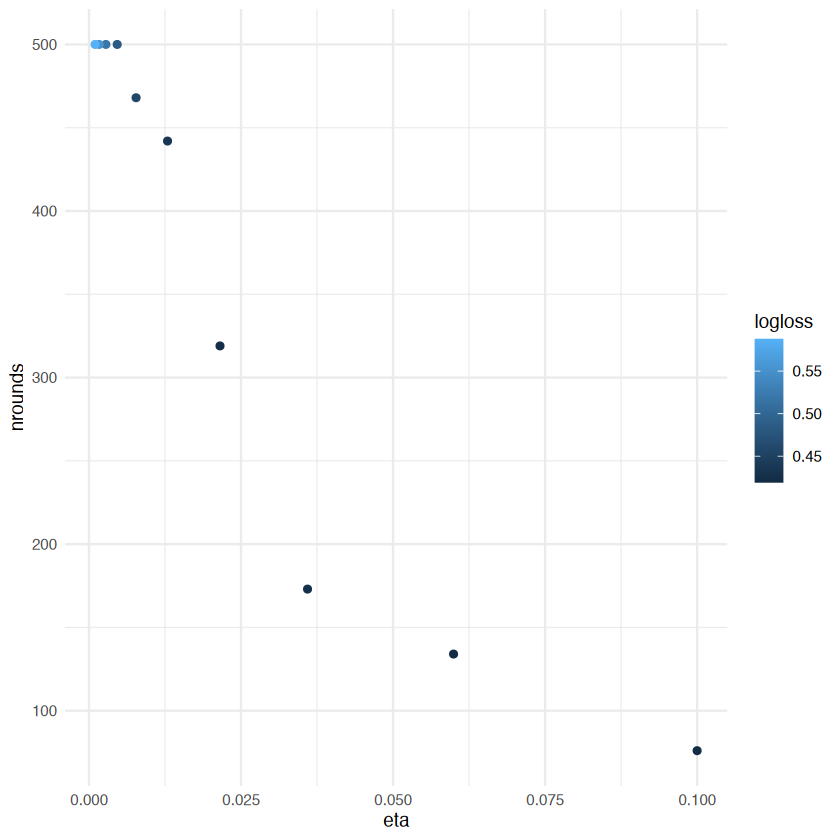

In [31]:
d <- ti$archive$data

d <- data.table(
  eta = exp(d$eta),
  nrounds = unlist(d$internal_tuned_values),
  logloss = d$logloss
)

library(ggplot2)
ggplot(data = d, aes(x = eta, y = nrounds, color = logloss)) +
  geom_point() +
  theme_minimal()

In [32]:
at <- auto_tuner(
  tuner = tnr("grid_search"),
  learner = lrn_xgb,
  resampling = rsmp("cv", folds = 3),
  measure = msr(
    "internal_valid_score",
    select = "logloss",
    minimize = TRUE
  ),
  term_evals = 10L
)
at$train(tsk_sonar)

INFO  [15:08:30.376] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [15:08:30.413] [bbotk] Evaluating 1 configuration(s)
INFO  [15:08:30.424] [mlr3] Running benchmark with 3 resampling iterations
INFO  [15:08:30.428] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/3)
INFO  [15:08:30.823] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 2/3)
INFO  [15:08:31.294] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 3/3)
INFO  [15:08:31.688] [mlr3] Finished benchmark
INFO  [15:08:31.705] [bbotk] Result of batch 1:
INFO  [15:08:31.706] [bbotk]       eta  logloss warnings errors runtime_learners internal_tuned_values
INFO  [15:08:31.706] [bbotk]  -6.39607 0.551799        0      0            1.215             <list[1]>
INFO  [15:08:31.706] [bbotk]                                 uhash
INFO  [15:08:31.706] [bbotk]  3a5da6d8-d8ff-48d0-a827-1ba2d61dfd56
INFO  [15:08:31.708]

In [ ]:
lrn_xgb$param_set$set_values(
  eta = 0.1,
  nrounds = 500,
  early_stopping_rounds = 10
)
lrn_xgb$predict_sets <- "test"

design <- benchmark_grid(
  tsk_sonar,
  list(lrn_xgb, lrn("classif.rpart")),
  rsmp("cv", folds = 3)
)
bmr <- benchmark(design)
bmr$aggregate(msr("classif.ce"))

# nr resample_result            task_id learner_id      resampling_id iters
# 1 1  <environment: 0x162bb24a0> sonar   classif.xgboost cv            3    
# 2 2  <environment: 0x162b96ab8> sonar   classif.rpart   cv            3    
#   classif.ce
# 1 0.1488613 
# 2 0.2930987

INFO  [15:10:50.632] [mlr3] Running benchmark with 6 resampling iterations
INFO  [15:10:50.639] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/3)
INFO  [15:10:50.735] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 2/3)
INFO  [15:10:50.827] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 3/3)
INFO  [15:10:50.928] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/3)
INFO  [15:10:51.006] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/3)
INFO  [15:10:51.020] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/3)
INFO  [15:10:51.033] [mlr3] Finished benchmark


nr,resample_result,task_id,learner_id,resampling_id,iters,classif.ce
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x162bb24a0>,sonar,classif.xgboost,cv,3,0.1488613
2,<environment: 0x162b96ab8>,sonar,classif.rpart,cv,3,0.2930987


In [35]:
search_space <- ps(
  eta = p_dbl(lower = 0.001, upper = 0.1, logscale = TRUE),
  nrounds = p_int(
    lower = 1,
    upper = 500,
    tags = "internal_tuning",
    aggr = function(x) as.integer(mean(unlist(x)))
  )
)

In [36]:
at <- auto_tuner(
  tuner = tnr("grid_search"),
  learner = lrn_xgb,
  resampling = rsmp("cv", folds = 3),
  measure = msr(
    "internal_valid_score",
    select = "logloss",
    minimize = TRUE
  ),
  search_space = search_space,
  term_evals = 10L
)
at$train(tsk_sonar)

INFO  [15:12:32.558] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [15:12:32.563] [bbotk] Evaluating 1 configuration(s)
INFO  [15:12:32.569] [mlr3] Running benchmark with 3 resampling iterations
INFO  [15:12:32.575] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/3)
INFO  [15:12:32.636] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 2/3)
INFO  [15:12:32.698] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 3/3)
INFO  [15:12:32.769] [mlr3] Finished benchmark
INFO  [15:12:32.786] [bbotk] Result of batch 1:
INFO  [15:12:32.788] [bbotk]        eta   logloss warnings errors runtime_learners internal_tuned_values
INFO  [15:12:32.788] [bbotk]  -2.814271 0.4401655        0      0            0.154             <list[1]>
INFO  [15:12:32.788] [bbotk]                                 uhash
INFO  [15:12:32.788] [bbotk]  f37028ea-22c8-4a7c-85b3-3fa03ef6ac24
INFO  [15:12:32.